In [114]:
# 1. Imports
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [115]:
# Load dataset
df = pd.read_csv('../data/car_data.csv')

df4=pd.read_csv('../data/car_data4.csv')


# Drop unnecessary index column
df.drop(columns=['Unnamed: 0'], inplace=True)
# remove duplicates if any
df = df.drop_duplicates()


In [116]:
df = pd.concat([df4, df], ignore_index=True)

In [117]:
df

,name,Price,year,fuel_type,kms_driven,company
0,Maruti Celerio,400000.0,2015,Petrol,120000.0,Maruti
1,Ford Ecosport,811000.0,2018,Petrol,32706.0,Ford
2,Tata Tiago,585000.0,2018,Petrol,11949.0,Tata
3,Hyundai Xcent,462000.0,2014,Petrol,17794.0,Hyundai
4,Maruti SX4 S Cross,790000.0,2015,Diesel,60000.0,Maruti
...,...,...,...,...,...,...
8226,Maruti Suzuki Ritz,270000.0,2011,Petrol,50000.0,Maruti
8227,Tata Indica V2,110000.0,2009,Diesel,30000.0,Tata
8228,Toyota Corolla Altis,300000.0,2009,Petrol,132000.0,Toyota
8229,Tata Zest XM,260000.0,2018,Diesel,27000.0,Tata


In [118]:
# Extract model (excluding brand name)
df['model'] = df['name'].apply(lambda x: ' '.join(x.split()[1:]))


In [119]:
# Convert year to car age
df['car_age'] = 2025 - df['year']

# Drop original 'name' and 'year' columns
df = df.drop(['name', 'year'], axis=1)


In [120]:
df

,Price,fuel_type,kms_driven,company,model,car_age
0,400000.0,Petrol,120000.0,Maruti,Celerio,10
1,811000.0,Petrol,32706.0,Ford,Ecosport,7
2,585000.0,Petrol,11949.0,Tata,Tiago,7
3,462000.0,Petrol,17794.0,Hyundai,Xcent,11
4,790000.0,Diesel,60000.0,Maruti,SX4 S Cross,10
...,...,...,...,...,...,...
8226,270000.0,Petrol,50000.0,Maruti,Suzuki Ritz,14
8227,110000.0,Diesel,30000.0,Tata,Indica V2,16
8228,300000.0,Petrol,132000.0,Toyota,Corolla Altis,16
8229,260000.0,Diesel,27000.0,Tata,Zest XM,7


In [121]:
# Define target and features
X = df.drop('Price', axis=1)
y = df['Price']


In [122]:
for col in ['company', 'fuel_type', 'model']:
    means = df.groupby(col)['Price'].mean()
    X[col] = X[col].map(means)


In [123]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [124]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the XGBoost Regressor with the best parameters
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    subsample=0.8,
    n_estimators=200, 
    max_depth=10,
    learning_rate=0.05,
    gamma=5,
    colsample_bytree=0.6,
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


MAE: 88420.97
RMSE: 129831.71
R² Score: 0.8805


In [125]:
# from sklearn.model_selection import RandomizedSearchCV

# params = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 1, 5]
# }

# xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
# search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=10, cv=3, verbose=1, n_jobs=1)

# search.fit(X_train, y_train)

# print("Best Params:", search.best_params_)


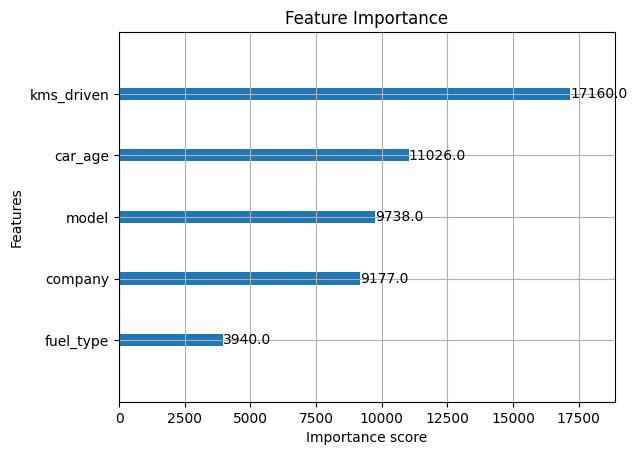

In [126]:
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()


In [127]:
import joblib
joblib.dump(model, '../models/xgb_model.pkl')


['../models/xgb_model.pkl']

In [128]:
#✅ 1. Actual vs Predicted Prices

import plotly.express as px
import pandas as pd

df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

fig = px.scatter(df_pred, x='Actual', y='Predicted',
                 title='Actual vs Predicted Car Prices',
                 labels={'Actual': 'Actual Price', 'Predicted': 'Predicted Price'},
                 trendline='ols')
fig.update_traces(marker=dict(size=8, color='dodgerblue'), selector=dict(mode='markers'))
fig.show()


In [129]:
#✅ 2. Residual Plot

residuals = y_test - y_pred
df_res = pd.DataFrame({'Predicted': y_pred, 'Residuals': residuals})

fig = px.scatter(df_res, x='Predicted', y='Residuals',
                 title='Residuals vs Predicted Price',
                 labels={'Predicted': 'Predicted Price', 'Residuals': 'Residuals'})
fig.add_hline(y=0, line_dash="dash", line_color="red")
fig.show()


In [130]:
fig = px.histogram(y, nbins=30,
                   title='Distribution of Car Prices',
                   labels={'value': 'Car Price'},
                   color_discrete_sequence=['indianred'])
fig.update_layout(bargap=0.2)
fig.show()
